In [2]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [3]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [11]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[1])

h


In [20]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["gpt2", "p50k_base", "cl100k_base"]:
        encoding = tiktoken.get_encoding(encoding_name)
        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

compare_encodings("hello, I'm your old brother! you don't know who I am")
compare_encodings("2 + 2 = 4")
compare_encodings("お誕生日おめでとう")


Example string: "hello, I'm your old brother! you don't know who I am"

gpt2: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

p50k_base: 15 tokens
token integers: [31373, 11, 314, 1101, 534, 1468, 3956, 0, 345, 836, 470, 760, 508, 314, 716]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

cl100k_base: 15 tokens
token integers: [15339, 11, 358, 2846, 701, 2362, 10868, 0, 499, 1541, 956, 1440, 889, 358, 1097]
token bytes: [b'hello', b',', b' I', b"'m", b' your', b' old', b' brother', b'!', b' you', b' don', b"'t", b' know', b' who', b' I', b' am']

Example string: "2 + 2 = 4"

gpt2: 5 tokens
token integers: [17, 1343, 362, 796, 604]
token bytes: [b'2', b' +', b' 2', b' =', b' 4']

p50k_base: 5 tokens


In [4]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [21]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [6]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [7]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [8]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [9]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [13]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data.to('cpu')) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data.to('cpu'))

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [14]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


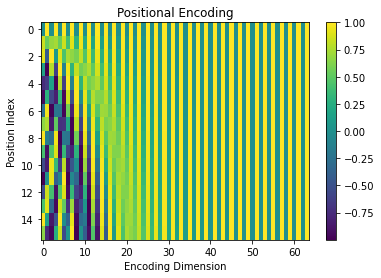

In [15]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [16]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.399742,-0.206918,0.327990,0.748870,0.531874,0.751807,0.351938,0.610762,0.129977,-0.207580,...,-0.547752,2.515671,1.223743,1.833670,-0.404194,1.563555,0.591292,0.275255,1.670105,0.758279
1,1.407957,-0.561974,2.393893,0.377252,1.083746,0.138066,-0.334590,1.670161,0.329176,2.342795,...,0.873984,2.226714,0.794747,1.598629,0.884658,1.032520,1.353795,1.059697,1.172643,1.527427
2,0.482819,1.301215,0.653670,-0.846175,0.628521,1.126829,-0.102938,-0.636202,0.428573,0.553769,...,-0.934116,2.145729,-1.913517,0.552654,0.597746,2.673483,-1.969119,1.397835,-0.438208,0.437077
3,0.851059,0.379319,0.070685,0.910763,-1.117662,0.325378,0.947827,0.472564,0.516017,0.790074,...,0.072798,0.264451,0.070916,-1.744750,1.088080,0.002188,0.715526,-0.357311,1.604357,1.920290
4,-2.720048,-0.354717,0.272903,-0.906938,0.932237,-1.449321,-0.226828,-1.203768,2.488952,2.130765,...,0.533600,0.432145,-2.389682,0.913403,0.066965,1.655225,0.625080,0.236625,-0.692241,0.992275
5,-0.147775,0.718796,0.559903,-0.004127,-0.690035,-0.998508,0.331355,-1.222723,0.836060,-1.353497,...,-0.044886,-0.201054,-0.926252,1.322522,0.587324,1.108183,-1.652407,2.918813,0.942309,1.584330
6,0.038134,3.066611,-1.069607,0.424900,-1.142844,-2.948736,0.505219,-0.617680,1.280667,-0.168857,...,0.202646,1.051821,1.306703,1.517673,0.050767,1.044631,1.347860,0.678610,-0.477987,0.833080
7,-1.368717,2.010294,-1.177933,1.943613,0.931115,-2.610583,-0.812628,-1.958096,2.302625,0.242536,...,-2.336618,1.190780,-0.052987,3.281737,-0.415515,0.198294,-1.392472,2.863094,-0.392633,0.868254
8,3.896336,-0.053480,-1.065470,1.569054,-1.767442,-0.238040,-1.386770,-0.574759,0.118923,-1.069920,...,3.366446,0.203255,1.759607,2.526687,-0.652322,2.660683,0.966853,1.618786,1.664013,2.768385
9,1.811860,-2.118048,0.777184,0.642304,-0.407949,0.093468,-0.256171,-1.183092,0.421236,-2.164224,...,-0.543957,2.515664,1.226589,1.833666,-0.402059,1.563552,0.592893,0.275254,1.671305,0.758279


In [17]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [18]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.843055 -0.550052 -0.127732 -0.844840 -0.819225  0.063522 -0.187879  1.182711 -1.542636  0.582238  0.123996 -0.023149  0.141312  0.812356 -1.628145  0.312126
1 -0.350486  0.484634 -0.140094  0.746821  1.481563 -0.266805  0.312059 -0.710153 -0.557109  0.462987 -0.575465  0.824084 -0.910005 -0.060633 -0.851140 -0.696344
2 -0.140998 -0.055692 -0.718412 -0.797249  0.366570  1.513673  0.577341 -0.707247 -0.275017  1.270264 -0.846118 -1.158900  1.652279  0.261800 -0.884520 -0.846511
3 -0.244500  0.759894  0.067822  0.388658 -0.178537  1.044808 -0.276759 -0.887757 -0.158977 -0.619547 -0.298364 -0.604880 -1.250720  0.388842 -1.088377  0.081781
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.614938 -0.657467  0.080

In [19]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,0.872087,0.805252,0.638937,0.403635,-0.220579,0.074281,0.066307,0.161097,0.776864,-0.015753,0.059171,-0.167397,-0.519080,-0.113654,0.370162
1,1.123528,0.464093,0.514921,-0.184883,0.292599,-0.127225,0.205937,0.207777,0.602376,1.016719,0.158707,0.074483,0.526718,0.460966,0.633765,0.534267
2,1.040623,0.605708,0.119165,-0.133348,-0.169015,-0.146091,0.444743,0.050206,0.774002,0.830742,-0.216136,-0.111672,0.751038,0.496729,0.747770,0.609336
3,0.900045,0.596818,0.359724,0.836026,0.074438,0.652813,1.057635,-0.026944,1.124048,0.971823,-0.467323,-0.247706,0.002623,-0.360195,0.017813,0.965252
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-0.448183,-0.238576,-0.078154,-0.033891,0.852194,0.056048,0.533376,0.968322,0.675573,0.506570,0.651593
5,0.071058,0.273445,0.044782,0.250272,-0.114290,0.121239,0.472959,0.086112,-0.077087,-0.158122,-0.416886,0.212225,0.220158,-0.492304,0.175022,0.505993
6,0.897961,1.322748,0.553525,0.079147,0.502846,-0.506932,0.223247,-0.400829,0.203914,0.658943,-0.018270,0.620022,0.600703,0.066074,0.316328,0.332746
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-0.025749,0.031660,0.079259,0.274235,0.095197,-0.625557,-0.000797,0.226548
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,0.642808,0.532076,0.191681,-0.066689,0.383821,-0.080174,0.330104
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,0.184269,0.238904,-0.084467,-0.414828,-0.173580,0.431657


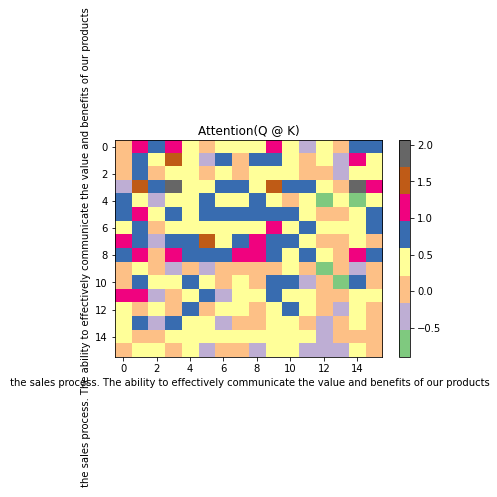

In [20]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.827912,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,1.123528,0.464093,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.040623,0.605709,0.119165,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.900045,0.596818,0.359724,0.836026,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,1.061119,1.158659,0.633724,-0.320907,0.383561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.071058,0.273445,0.044782,0.250272,-0.114290,0.121239,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.897961,1.322748,0.553525,0.079147,0.502846,-0.506932,0.223247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.025299,0.779429,0.627483,-0.354743,0.218848,-0.055096,0.297431,-0.119230,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.529123,-0.196815,0.232964,0.031045,0.214278,-0.328799,-0.685732,0.060671,0.237945,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.935247,0.690427,0.511019,1.063499,0.504674,-0.227777,-0.035515,-0.006277,0.174739,0.899135,-inf,-inf,-inf,-inf,-inf,-inf


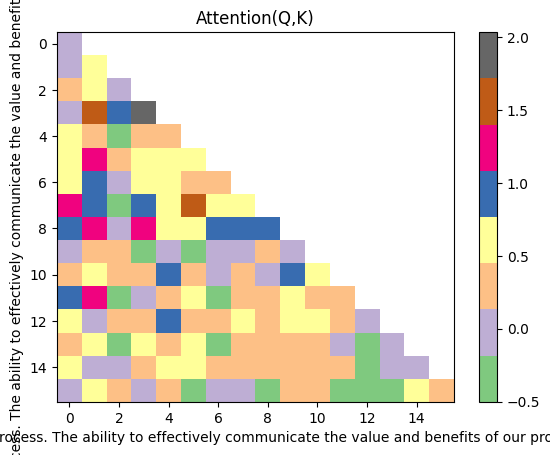

In [27]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [21]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.102015,0.106622,0.099729,0.084449,0.066742,0.035753,0.048014,0.047632,0.052368,0.096938,0.043880,0.047294,0.037706,0.026526,0.039787,0.064545
1,0.120328,0.062227,0.065472,0.032519,0.052420,0.034449,0.048069,0.048157,0.071455,0.108139,0.045851,0.042148,0.066249,0.062033,0.073734,0.066751
2,0.113864,0.073706,0.045311,0.035200,0.033966,0.034754,0.062748,0.042292,0.087216,0.092307,0.032403,0.035971,0.085236,0.066096,0.084957,0.073974
3,0.089973,0.066439,0.052415,0.084394,0.039406,0.070266,0.105331,0.035606,0.112563,0.096669,0.022923,0.028553,0.036675,0.025515,0.037236,0.096036
4,0.108003,0.119068,0.070440,0.027116,0.054850,0.023876,0.029443,0.034566,0.036131,0.087640,0.039531,0.063715,0.098431,0.073450,0.062029,0.071710
5,0.060262,0.073780,0.058699,0.072090,0.050066,0.063363,0.090071,0.061176,0.051964,0.047919,0.036994,0.069398,0.069951,0.034307,0.066864,0.093096
6,0.098720,0.150970,0.069955,0.043531,0.066498,0.024225,0.050278,0.026937,0.049316,0.077733,0.039491,0.074765,0.073335,0.042966,0.055183,0.056097
7,0.055444,0.117862,0.101247,0.037915,0.067285,0.051161,0.072785,0.047983,0.052685,0.055798,0.058518,0.071116,0.059459,0.028920,0.054016,0.067805
8,0.088689,0.042914,0.065955,0.053896,0.064734,0.037608,0.026319,0.055517,0.066284,0.099367,0.088951,0.063288,0.048878,0.076695,0.048223,0.072684
9,0.107969,0.084523,0.070641,0.122743,0.070194,0.033744,0.040898,0.042111,0.050468,0.104139,0.050951,0.053812,0.038944,0.027988,0.035624,0.065252


In [22]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [23]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [25]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.160987,0.310978,-0.085141,-0.227763,0.102594,-0.253544,0.059533,0.190659,0.037080,-0.313819,...,0.202746,0.091802,-0.417809,0.358321,0.323687,0.339211,0.263343,-0.098039,-0.148667,0.182895
1,-0.133180,0.295035,-0.129012,-0.278895,0.217745,-0.243995,0.103712,0.161087,0.030556,-0.330357,...,0.235571,0.092640,-0.391074,0.409027,0.320875,0.396577,0.307205,-0.071485,-0.211834,0.242537
2,-0.164291,0.360627,-0.114069,-0.191198,0.235169,-0.219537,0.147877,0.180772,0.018465,-0.303195,...,0.246254,0.111134,-0.362372,0.445795,0.293762,0.404231,0.292151,-0.077243,-0.163110,0.261572
3,-0.223549,0.282176,-0.119732,-0.254340,0.210661,-0.200929,0.195259,0.169062,0.052090,-0.245123,...,0.201146,0.199225,-0.295390,0.445179,0.353170,0.380003,0.268207,-0.061861,-0.082237,0.281301
4,-0.185855,0.335761,-0.108228,-0.194570,0.144118,-0.249600,0.110031,0.147648,0.048013,-0.355061,...,0.216234,0.069268,-0.403522,0.412288,0.262961,0.375550,0.295621,-0.052466,-0.195374,0.163996
5,-0.154714,0.324391,-0.079822,-0.155420,0.148139,-0.259291,0.113473,0.197752,0.081582,-0.324526,...,0.229448,0.053441,-0.383650,0.409380,0.233886,0.247970,0.315757,-0.113193,-0.190874,0.152359
6,-0.231247,0.343534,-0.126063,-0.209148,0.108791,-0.240719,0.079565,0.151679,-0.040719,-0.320127,...,0.168814,0.102834,-0.368248,0.464032,0.263377,0.409909,0.270343,-0.071631,-0.167951,0.243212
7,-0.151951,0.386629,-0.044331,-0.136448,0.108837,-0.282499,0.189408,0.237718,0.026140,-0.220814,...,0.251051,0.059223,-0.389462,0.397424,0.289660,0.191832,0.319966,-0.146593,-0.104915,0.169207
8,-0.178167,0.335981,-0.110875,-0.178786,0.172179,-0.227869,0.193129,0.127293,0.014121,-0.237215,...,0.245830,0.109892,-0.346378,0.490377,0.320956,0.369653,0.260652,-0.078298,-0.082768,0.261684
9,-0.188816,0.308341,-0.089198,-0.236049,0.100889,-0.252645,0.067130,0.171645,0.040132,-0.315123,...,0.207996,0.120540,-0.404799,0.402407,0.325721,0.366890,0.242737,-0.088404,-0.112001,0.210526


In [26]:
# Add residual connection
output = output + X

In [27]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [28]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [29]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [39]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [30]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.570528,0.726460,-0.691391,-0.188735,-0.137170,0.106931,-0.396504,0.241502,-0.276662,-0.192252,...,-0.289596,-0.297091,0.491122,-0.104293,0.133864,0.837469,-0.925577,-0.733771,-0.758316,0.682130
1,-0.012040,-0.432935,0.447067,-0.392089,0.517174,-0.007110,-0.714715,0.303965,-0.065587,0.241557,...,-1.360065,-0.076440,0.188735,0.795213,-0.693781,0.336113,-0.606569,-1.017391,-1.067663,0.244303
2,0.831333,0.518270,0.107214,0.143476,0.210689,0.042693,0.191517,0.414418,-0.590847,0.185385,...,-0.186266,-0.265145,-0.090333,0.623118,-0.209745,-0.083961,-0.861654,-1.587315,-0.580822,-0.213220
3,0.530551,0.122118,-0.637526,0.987713,0.021701,0.094364,1.308995,-0.013947,0.202528,-0.518164,...,0.780999,-0.334294,0.257278,0.322762,0.564934,0.012172,0.504941,-0.758731,-0.476354,-0.185660
4,0.489544,-0.280772,0.594447,0.356109,0.204343,-0.314539,-1.034038,-0.516889,0.063465,-0.325223,...,0.095474,-0.186922,0.258232,1.055995,-0.695072,0.953611,0.122320,-0.260491,0.284999,-0.008202
5,-0.122122,-0.250793,0.201239,1.011567,0.352451,0.133038,0.000802,-0.962664,0.558585,-0.200383,...,-0.552772,-0.054458,1.472380,1.412593,0.003201,0.492287,0.692858,-0.784277,0.503241,-0.116631
6,0.372707,-0.124261,0.162850,0.662560,0.587255,-0.171247,0.112446,-0.704085,-0.542221,-0.179474,...,0.089490,0.542794,-0.144937,0.336223,-0.486196,0.725454,0.461130,-0.469143,-0.255056,-0.266089
7,0.004788,-0.683094,-0.396198,-0.648946,1.006132,-0.822922,1.005377,-0.842731,-0.021846,0.087007,...,0.137511,0.569512,-0.185690,0.044604,-0.861628,-0.048843,0.316381,1.032601,0.326896,0.455284
8,-0.842826,-1.040122,0.075339,-0.543102,1.072257,-0.354048,-0.007888,-0.467999,-0.571449,0.403229,...,0.006492,-0.003120,0.193944,-0.052414,0.061557,-0.086287,-0.161801,-0.628783,-0.617159,0.746197
9,0.213020,0.489887,-0.654601,-0.103123,0.412443,-0.046390,-0.265254,0.355545,-0.287117,-0.455135,...,-0.471290,-0.310776,0.714655,0.259003,0.445099,0.595565,-0.585229,-0.533957,-0.721235,0.739523


In [41]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000002,0.000007,0.000006,0.000006,0.000014,0.000006,0.000013,0.000016,0.000004,0.000008,...,0.000004,0.000005,0.000010,0.000018,0.000007,0.000014,0.000016,0.000011,0.000021,0.000003
1,0.000008,0.000011,0.000007,0.000007,0.000018,0.000004,0.000013,0.000007,0.000005,0.000009,...,0.000012,0.000009,0.000016,0.000014,0.000008,0.000006,0.000006,0.000006,0.000014,0.000007
2,0.000009,0.000011,0.000005,0.000003,0.000014,0.000004,0.000018,0.000005,0.000008,0.000006,...,0.000016,0.000003,0.000027,0.000020,0.000006,0.000011,0.000006,0.000005,0.000014,0.000005
3,0.000007,0.000007,0.000007,0.000006,0.000014,0.000004,0.000007,0.000010,0.000003,0.000002,...,0.000010,0.000008,0.000007,0.000004,0.000004,0.000004,0.000012,0.000013,0.000003,0.000004
4,0.000008,0.000017,0.000015,0.000009,0.000003,0.000007,0.000020,0.000005,0.000006,0.000010,...,0.000012,0.000008,0.000016,0.000041,0.000008,0.000034,0.000009,0.000008,0.000006,0.000002
5,0.000008,0.000022,0.000005,0.000010,0.000005,0.000005,0.000015,0.000005,0.000008,0.000010,...,0.000004,0.000008,0.000012,0.000005,0.000003,0.000003,0.000006,0.000007,0.000006,0.000004
6,0.000020,0.000014,0.000006,0.000012,0.000011,0.000013,0.000010,0.000005,0.000009,0.000005,...,0.000011,0.000020,0.000005,0.000020,0.000004,0.000006,0.000006,0.000016,0.000003,0.000004
7,0.000018,0.000011,0.000003,0.000013,0.000004,0.000012,0.000006,0.000006,0.000004,0.000019,...,0.000008,0.000022,0.000004,0.000008,0.000003,0.000023,0.000013,0.000005,0.000009,0.000002
8,0.000011,0.000007,0.000004,0.000005,0.000012,0.000032,0.000007,0.000009,0.000010,0.000002,...,0.000005,0.000010,0.000010,0.000009,0.000006,0.000005,0.000003,0.000010,0.000011,0.000008
9,0.000004,0.000011,0.000005,0.000005,0.000011,0.000009,0.000014,0.000013,0.000007,0.000005,...,0.000003,0.000005,0.000011,0.000024,0.000007,0.000015,0.000009,0.000011,0.000016,0.000004


In [31]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

'PUT'

In [32]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'

In [ ]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html